In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import math
import torch
from torch.utils import model_zoo
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from models_n_training import *
from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split, dianostic_plots, pad_for_detector
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla K80


In [3]:
# Subset sampling: save to me_samples; "me" for "mutually exclusive"
output_folder_path = "../../../../temp/buffers/me_samples"

data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"

len(os.listdir(data_dir)) # total number of regions

3543

Uncomment the following code chunk to resample training and validation data

In [4]:
# !rm -r /home/ubuntu/data/temp/train
# !mkdir /home/ubuntu/data/temp/train
# !rm -r /home/ubuntu/data/temp/val
# !mkdir /home/ubuntu/data/temp/val

# ###############################################################################
# # Sample training and validation data
# # IMPORTANT: Make sure that training and validation don't have intersection!!!
# ###############################################################################
# all_data_lst = np.array(os.listdir(data_dir))
# n = len(all_data_lst)
# num_trained_regions = int(n * 0.8)
# train_files = all_data_lst[:num_trained_regions]
# num_val = n - num_trained_regions
# val_indices = np.random.choice(np.arange(num_trained_regions, n), num_val, replace = False)
# val_files = all_data_lst[val_indices]

# train_dest = '/home/ubuntu/data/temp/train/'
# for file in train_files:
#     shutil.copy(os.path.join(data_dir, file),
#                           train_dest)
# print('copied training samples to {}'.format(train_dest))

# val_dest = '/home/ubuntu/data/temp/val/'
# for file in val_files:
#     shutil.copy(os.path.join(data_dir, file),
#                           val_dest)
# print('copied validation samples to {}'.format(val_dest))

# # Preprocess train and val data so that they are ready to be fed to models
# train_output_path = os.path.join(output_folder_path, 'train.data')
# val_output_path = os.path.join(output_folder_path, 'val.data')

# train_regions = one_hot_encoding(train_dest, train_output_path)
# val_regions = one_hot_encoding(val_dest, val_output_path)
# train_x, train_y = get_training_data(train_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'train_x.data', 
#                                    train_y_name = 'train_y.data')
# val_x, val_y = get_training_data(val_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'val_x.data', 
#                                    train_y_name = 'val_y.data')
# # Pad for motif detectors
# train_x, val_x = pad_for_detector(train_x, 15), pad_for_detector(val_x, 15)

In [5]:
# data_x = pickle.load(open('../../../../temp/buffers/ss_samples/train_x.data', 'rb'))
# data_y = pickle.load(open('../../../../temp/buffers/ss_samples/train_y.data', 'rb'))
# train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)
# train_x, val_x = pad_for_detector(train_x, 10), pad_for_detector(val_x, 10)

In [6]:
train_x = pickle.load(open(os.path.join(output_folder_path, 'train_x.data'), 'rb'))
train_y = pickle.load(open(os.path.join(output_folder_path, 'train_y.data'), 'rb'))
val_x = pickle.load(open(os.path.join(output_folder_path, 'val_x.data'), 'rb'))
val_y = pickle.load(open(os.path.join(output_folder_path, 'val_y.data'), 'rb'))

In [7]:
n = 15 # number of filters
m = 30 # filter size
train_x, val_x = pad_for_detector(train_x, m), pad_for_detector(val_x, m)

In [8]:
train_x, val_x = torch.from_numpy(train_x.transpose([0, 2, 1])).float(), torch.from_numpy(val_x.transpose([0, 2, 1])).float()
train_y, val_y = torch.from_numpy(train_y).float(), torch.from_numpy(val_y).float()

# Generate dataset for data loader
train_dataset = data.TensorDataset(train_x, train_y)
val_dataset = data.TensorDataset(val_x, val_y)

In [9]:
class HybridNet(nn.Module):
    
    def __init__(self, pesudo_input, num_filters, filter_size, rnn_size, fc_out, dp1, dp2, 
                 num_rnn_layers=1, rnn_dropout=0):
        super(HybridNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=num_filters, kernel_size=filter_size)
        out = self.conv1(pesudo_input)
        out = nn.MaxPool1d(kernel_size=15, stride=15)(out)
        ####################################################
        print('shape after conv1d {}'.format(out.shape))
        N, C, T = out.shape
        out = torch.transpose(out, 1, 2)
        print('shape before lstm {}'.format(out.shape))
        ####################################################
        # or input_size*seq_len
        self.bi_lstm = nn.LSTM(input_size=C, hidden_size=rnn_size, num_layers=num_rnn_layers,
                              batch_first=True, dropout=rnn_dropout, bidirectional=True)
        out, _ = self.bi_lstm(out)
        print('shape after lstm {}'.format(out.shape))
        N, T, C = out.shape
        #out = torch.transpose(out, 1, 2)
        out = out.reshape(N, -1)
        print('shape after flattening {}'.format(out.shape))
        self.fc1 = nn.Linear(T*C, fc_out, bias=True)
        self.fc2 = nn.Linear(fc_out, 1)
        self.p1 = dp1
        self.p2 = dp2
        
    def forward(self, seq):
        self.activation_seq = F.relu(self.conv1(seq))
        out = nn.MaxPool1d(kernel_size=15, stride=15)(self.activation_seq)
        
#         out = nn.Dropout(p=self.p1)(self.activation_seq)
        
        #################################################################################
        # Input of LSTM layer should have shape (sequence_length, batch_size, input_size)
        #     - Sequence length here should be the length of activation after downsampling
        #     - Input size should be the number of filters
        #################################################################################
        N, C, T = out.shape
#         out = out.view(bs, 1, -1)
        out = torch.transpose(out, 1, 2)
        out, _ = self.bi_lstm(out)
        out = F.relu(out)
        
        #################################################################################
        # Need to flatten the sequence before feeding them into fully connected layer
        #################################################################################
        N, T, C = out.shape
        #out = torch.transpose(out, 1, 2)
        out = out.reshape(N, -1)
        out = self.fc1(out)
        out = nn.Dropout(p=self.p1)(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = nn.Dropout(p=self.p2)(out)
        out = torch.squeeze(out)
        return nn.Sigmoid()(out)

In [10]:
batch_size = 256
_, C, L = train_x.shape
pesudo_input = torch.rand(batch_size, C, L, dtype=train_x.dtype)
hybrid_net = HybridNet(pesudo_input,
                       num_filters=50, 
                       filter_size=10, 
                       rnn_size=50, 
                       fc_out=20, 
                       dp1=0.8, dp2=0.8).to(device)

optimizers = {'adam': torch.optim.Adam(hybrid_net.parameters(), lr=1e-3, weight_decay=1e-4),
              'rmsprop': torch.optim.RMSprop(hybrid_net.parameters(), lr=1e-3, weight_decay=1e-4)}
config = {'epochs':250, 'device':device, 
          'opt': optimizers['adam'],
          'criterion':nn.BCELoss(),
          'batch_size': batch_size,
          'log_interval':1}

hybrid_net, train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(hybrid_net, train_dataset, val_dataset, config)

shape after conv1d torch.Size([256, 50, 69])
shape before lstm torch.Size([256, 69, 50])
shape after lstm torch.Size([256, 69, 100])
shape after flattening torch.Size([256, 6900])
Train on 33984 samples, validate on 8520 samples
***************************************
Epoch 1: training loss 0.6945885285399014, training acc 0.45184249686716793
Time: 8.944575309753418 

[Validation loss 0.6917566727189457, validation acc 0.5013148488562091] 

***************************************
Epoch 2: training loss 0.6919588666213187, training acc 0.46284656954887216
Time: 8.870245218276978 

[Validation loss 0.6917154613663169, validation acc 0.5055147058823529] 

***************************************
Epoch 3: training loss 0.6914251841100535, training acc 0.46656680764411024
Time: 8.873063564300537 

[Validation loss 0.6928302733337178, validation acc 0.4980596405228758] 

***************************************
Epoch 4: training loss 0.6912454483204318, training acc 0.4690143327067669
Time: 8.

***************************************
Epoch 38: training loss 0.6913776326000243, training acc 0.4643248746867168
Time: 8.662974834442139 

[Validation loss 0.6926921115202063, validation acc 0.4958639705882353] 

***************************************
Epoch 39: training loss 0.6915836589676994, training acc 0.46371788847117795
Time: 8.691602230072021 

[Validation loss 0.6947137993924758, validation acc 0.4936044730392157] 

***************************************
Epoch 40: training loss 0.6905575887601179, training acc 0.47114857456140347
Time: 8.638310194015503 

[Validation loss 0.6922141383675968, validation acc 0.5019148284313726] 

***************************************
Epoch 41: training loss 0.691173783818582, training acc 0.4653038847117794
Time: 8.664510250091553 

[Validation loss 0.6929605883710525, validation acc 0.49974468954248363] 

***************************************
Epoch 42: training loss 0.6910626964461535, training acc 0.467359805764411
Time: 8.62473988533

***************************************
Epoch 76: training loss 0.6911449091775077, training acc 0.46410949248120303
Time: 8.606868505477905 

[Validation loss 0.6907022735651802, validation acc 0.5017233455882353] 

***************************************
Epoch 77: training loss 0.6907491867703602, training acc 0.46625352443609025
Time: 8.662714004516602 

[Validation loss 0.6913405516568352, validation acc 0.5020552491830065] 

***************************************
Epoch 78: training loss 0.6902151103306534, training acc 0.46570527882205515
Time: 8.682864427566528 

[Validation loss 0.6952743582865771, validation acc 0.4863408905228758] 

***************************************
Epoch 79: training loss 0.690439860623582, training acc 0.46795700187969924
Time: 8.619529962539673 

[Validation loss 0.6919724450391882, validation acc 0.5013914419934641] 

***************************************
Epoch 80: training loss 0.6901764833837524, training acc 0.4659402412280702
Time: 8.672414541

***************************************
Epoch 114: training loss 0.6885747170089779, training acc 0.4679667919799499
Time: 8.699142456054688 

[Validation loss 0.6924321230720071, validation acc 0.501953125] 

***************************************
Epoch 115: training loss 0.6884279618585917, training acc 0.46895559210526316
Time: 8.663673877716064 

[Validation loss 0.6931619872065151, validation acc 0.5001914828431373] 

***************************************
Epoch 116: training loss 0.6879110883053084, training acc 0.46673323934837097
Time: 8.672037601470947 

[Validation loss 0.6958587905939888, validation acc 0.4997063929738562] 

***************************************
Epoch 117: training loss 0.686982680532269, training acc 0.47153038847117795
Time: 8.72741436958313 

[Validation loss 0.6950113755815169, validation acc 0.4969618055555556] 

***************************************
Epoch 118: training loss 0.6870026512253553, training acc 0.4687793703007519
Time: 8.7232036590576

***************************************
Epoch 152: training loss 0.6810292135503956, training acc 0.47840303884711777
Time: 8.623216152191162 

[Validation loss 0.713581242982079, validation acc 0.5008552900326797] 

***************************************
Epoch 153: training loss 0.6804104962743315, training acc 0.47992050438596495
Time: 8.677459001541138 

[Validation loss 0.7095819273415733, validation acc 0.5060125612745098] 

***************************************
Epoch 154: training loss 0.6794958289404561, training acc 0.4795876409774436
Time: 8.657800912857056 

[Validation loss 0.7176710560041315, validation acc 0.5071359272875817] 

***************************************
Epoch 155: training loss 0.6794461809602895, training acc 0.47855968045112784
Time: 8.68556261062622 

[Validation loss 0.714961134335574, validation acc 0.5061785130718954] 

***************************************
Epoch 156: training loss 0.6778977638796756, training acc 0.48153587092731825
Time: 8.710298

[Validation loss 0.7158856514622184, validation acc 0.5052210988562091] 

***************************************
Epoch 190: training loss 0.6715027860232762, training acc 0.4913357612781955
Time: 3.952105760574341 

[Validation loss 0.7091250647516811, validation acc 0.5095230800653594] 

***************************************
Epoch 191: training loss 0.6753917004829063, training acc 0.4852756892230577
Time: 3.989576578140259 

[Validation loss 0.7154512019718394, validation acc 0.5039828431372549] 

***************************************
Epoch 192: training loss 0.6731107548663491, training acc 0.4878700657894737
Time: 3.9638900756835938 

[Validation loss 0.7120901539045221, validation acc 0.505233864379085] 

***************************************
Epoch 193: training loss 0.6739441349094075, training acc 0.48722391917293234
Time: 3.9602391719818115 

[Validation loss 0.719762030769797, validation acc 0.5035488153594772] 

***************************************
Epoch 194: traini

[Validation loss 0.7256521687788122, validation acc 0.502374387254902] 

***************************************
Epoch 228: training loss 0.6658573190968736, training acc 0.4936070645363408
Time: 3.9832804203033447 

[Validation loss 0.7234022652401644, validation acc 0.5009446486928105] 

***************************************
Epoch 229: training loss 0.6648449203125516, training acc 0.495124530075188
Time: 3.9590394496917725 

[Validation loss 0.7219820110236898, validation acc 0.5086294934640523] 

***************************************
Epoch 230: training loss 0.6652681899250001, training acc 0.4969748590225564
Time: 3.9615774154663086 

[Validation loss 0.7371719321783852, validation acc 0.5049785539215685] 

***************************************
Epoch 231: training loss 0.6680021743129071, training acc 0.4939007675438596
Time: 3.9693844318389893 

[Validation loss 0.7291626825052149, validation acc 0.5078125] 

***************************************
Epoch 232: training loss 

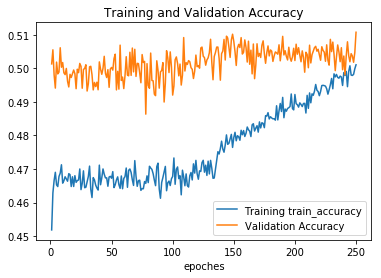

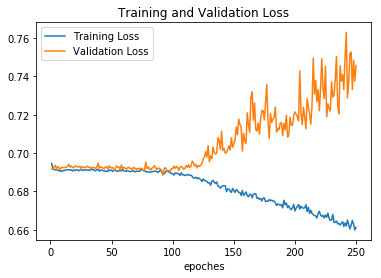

In [11]:
log_interval = 1
dianostic_plots(train_acc_list[::log_interval], train_loss_list[::log_interval], val_acc_list, val_loss_list)